# Image Classification using Support Vector Machine

In [1]:
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
DATA_DIR = './data'
TRAIN_DIR = f'{DATA_DIR}/training'
EVAL_DIR = f'{DATA_DIR}/eval'

# Directory creation for data
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(EVAL_DIR, exist_ok=True)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR100(root=TRAIN_DIR, download=True, train=True, transform=transform)
eval_dataset = CIFAR100(root=EVAL_DIR, download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Function to flatten images
def flatten_images(images):
    return images.view(images.size(0), -1)

# Prepare training data
train_data = [(flatten_images(image), label) for image, label in train_dataset]
train_df = pd.DataFrame(train_data, columns=["Image", "Label"])

# Flatten the image column further
train_df = pd.concat([train_df["Label"], train_df["Image"].apply(lambda x: pd.Series(x.numpy().flatten()))], axis=1)

# Prepare evaluation data
eval_data = [(flatten_images(image), label) for image, label in eval_dataset]
eval_df = pd.DataFrame(eval_data, columns=["Image", "Label"])

# Flatten the image column further
eval_df = pd.concat([eval_df["Label"], eval_df["Image"].apply(lambda x: pd.Series(x.numpy().flatten()))], axis=1)


In [5]:
train_df.head()

,Label,0,1,2,3,4,5,6,7,8,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.662745,-0.419608,-0.403922,-0.631373,-0.631373,-0.811765,-0.968627,-0.921569,-0.537255,-0.380392
1,29,1.000000,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,...,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,1.000000
2,0,0.960784,0.945098,0.937255,0.945098,0.952941,0.952941,0.945098,0.945098,0.937255,...,0.545098,0.537255,0.513726,0.498039,0.490196,0.482353,0.490196,0.521569,0.623529,0.788235
3,11,-0.027451,0.027451,0.058824,0.082353,0.098039,0.129412,0.160784,0.192157,0.223529,...,0.552941,0.615686,0.686275,0.694118,0.701961,0.733333,0.749020,0.819608,0.850980,0.811765
4,1,-0.662745,-0.749020,-0.317647,-0.003922,-0.568627,-0.623529,-0.600000,-0.317647,-0.050980,...,-0.701961,-0.505882,-0.450980,-0.576471,-0.403922,-0.607843,-0.388235,-0.529412,-0.772549,-0.709804


We have total (3*32*32) image features + 1 label

# Changing Labels to Coarse Labels
(Superclass labels)

In [6]:
subclass_to_superclass = {
    0: 'fruit and vegetables', 1: 'fish', 2: 'people', 3: 'large carnivores',
    4: 'aquatic mammals', 5: 'household furniture', 6: 'insects', 7: 'insects',
    8: 'vehicles 1', 9: 'food containers', 10: 'food containers', 11: 'people',
    12: 'large man-made outdoor things', 13: 'vehicles 1', 14: 'insects',
    15: 'large omnivores and herbivores', 16: 'food containers', 17: 'large man-made outdoor things',
    18: 'insects', 19: 'large omnivores and herbivores', 20: 'household furniture',
    21: 'large omnivores and herbivores', 22: 'household electrical devices', 23: 'large natural outdoor scenes',
    24: 'insects', 25: 'household furniture', 26: 'non-insect invertebrates', 27: 'reptiles',
    28: 'food containers', 29: 'reptiles', 30: 'aquatic mammals', 31: 'large omnivores and herbivores',
    32: 'fish', 33: 'large natural outdoor scenes', 34: 'medium-sized mammals', 35: 'people',
    36: 'small mammals', 37: 'large man-made outdoor things', 38: 'large omnivores and herbivores',
    39: 'household electrical devices', 40: 'household electrical devices', 41: 'vehicles 2', 42: 'large carnivores',
    43: 'large carnivores', 44: 'reptiles', 45: 'non-insect invertebrates', 46: 'people',
    47: 'trees', 48: 'vehicles 1', 49: 'large natural outdoor scenes', 50: 'small mammals',
    51: 'fruit and vegetables', 52: 'trees', 53: 'fruit and vegetables', 54: 'flowers',
    55: 'aquatic mammals', 56: 'trees', 57: 'fruit and vegetables', 58: 'vehicles 1',
    59: 'trees', 60: 'large natural outdoor scenes', 61: 'food containers', 62: 'flowers',
    63: 'medium-sized mammals', 64: 'medium-sized mammals', 65: 'small mammals', 66: 'medium-sized mammals',
    67: 'fish', 68: 'large man-made outdoor things', 69: 'vehicles 2', 70: 'flowers',
    71: 'large natural outdoor scenes', 72: 'aquatic mammals', 73: 'fish', 74: 'medium-sized mammals',
    75: 'medium-sized mammals', 76: 'large man-made outdoor things', 77: 'non-insect invertebrates',
    78: 'reptiles', 79: 'non-insect invertebrates', 80: 'small mammals', 81: 'vehicles 2',
    82: 'flowers', 83: 'fruit and vegetables', 84: 'household furniture', 85: 'vehicles 2',
    86: 'household electrical devices', 87: 'household electrical devices', 88: 'large carnivores',
    89: 'vehicles 2', 90: 'vehicles 1', 91: 'fish', 92: 'flowers', 93: 'reptiles',
    94: 'household furniture', 95: 'aquatic mammals', 96: 'trees', 97: 'large carnivores',
    98: 'people', 99: 'non-insect invertebrates'
}


In [7]:
train_df.Label = train_df.Label.replace(subclass_to_superclass)
eval_df.Label = eval_df.Label.replace(subclass_to_superclass)

In [8]:
train_df.head(2)

,Label,0,1,2,3,4,5,6,7,8,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,large omnivores and herbivores,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.662745,-0.419608,-0.403922,-0.631373,-0.631373,-0.811765,-0.968627,-0.921569,-0.537255,-0.380392
1,reptiles,1.0,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,...,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,1.000000


#### Label Encoding target column

In [9]:
label_encoder = LabelEncoder()
train_df.Label = label_encoder.fit_transform(train_df.Label)
eval_df.Label = label_encoder.transform(eval_df.Label)

#### Dimension Reduction

In [10]:
# Exclude the 'Label' column from X
X = train_df.drop(columns=['Label'])

# Reduce dimensionality using PCA
pca = PCA(n_components=500)
X_train = pca.fit_transform(X)
X_test = pca.transform(eval_df.drop(columns=['Label']))

In [11]:
y_train = train_df['Label']
y_test = eval_df['Label']

# Modeling

In [14]:
%%time
# Initialize SVM classifier
svm_classifier = SVC(kernel='rbf', decision_function_shape='ovo', class_weight='balanced', gamma='scale', C=1.0, cache_size=200, tol=1e-3)


# Train the classifier
svm_classifier.fit(X_train, y_train)

CPU times: user 10min 30s, sys: 1.09 s, total: 10min 31s
Wall time: 10min 37s


SVC(class_weight='balanced', decision_function_shape='ovo')

In [15]:
# Save the trained model to a file
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

In [16]:
# Evaluate the classifier
accuracy = svm_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.3794


In [17]:
y_pred = svm_classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

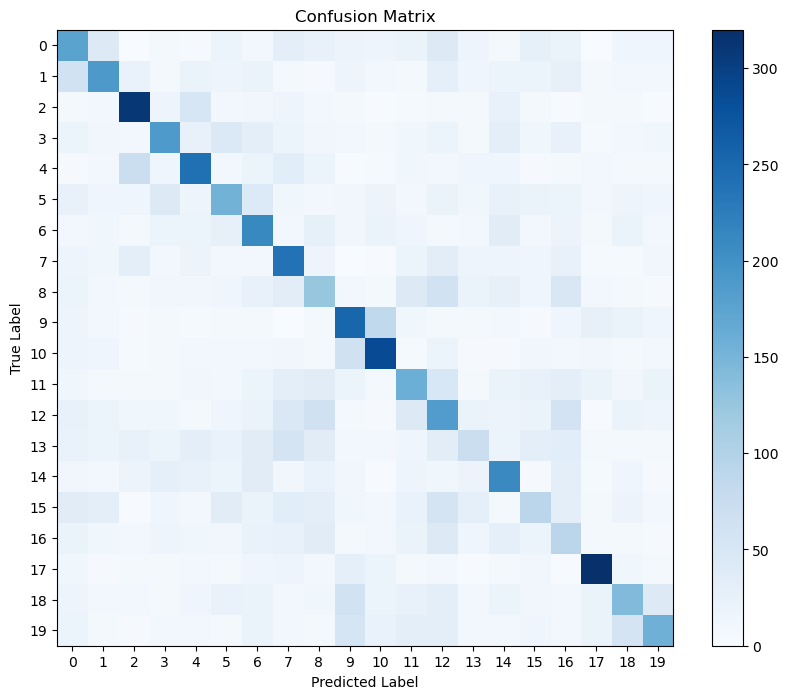

In [18]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(20))
plt.yticks(np.arange(20))
plt.grid(False)
plt.show()